Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder
# get rid of warnings
import warnings
warnings.filterwarnings("ignore")
# get more than one output per jupyter cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# for functions we implement later
from utils2 import best_fit_distribution
from utils2 import plot_result

Import the data

In [2]:
df = pd.read_csv("titanic_train.csv")

In [3]:
df.shape
df.head()

(891, 12)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We will drop all the columns that contain personal info and are unique identifier which will not serve for our learning model.
such as passenger ID and name. similar argument can be made for cabin and ticket.

In [4]:
df.drop(columns=["PassengerId", "Name"], inplace=True) # dropped because unique for every row
df.drop(columns=["Ticket", "Cabin"], inplace=True) # dropped because almost unique for every row
df.dropna(inplace=True)

The resulting data will look like this.

In [5]:
df.shape
df.head()

(712, 8)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


No we will encode the data such as sex and embarked to have numberical data and not general identifier.

In [6]:
encoders = [(["Sex"], LabelEncoder()), (["Embarked"], LabelEncoder())]
mapper = DataFrameMapper(encoders, df_out=True)
new_cols = mapper.fit_transform(df.copy())
df = pd.concat([df.drop(columns=["Sex", "Embarked"]), new_cols], axis="columns")

In [7]:
df.shape
df.head()

(712, 8)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked
0,0,3,22.0,1,0,7.2500,1,2
1,1,1,38.0,1,0,71.2833,0,0
2,1,3,26.0,0,0,7.9250,0,2
3,1,1,35.0,1,0,53.1000,0,2
4,0,3,35.0,0,0,8.0500,1,2


In [8]:
df.nunique()

Survived      2
Pclass        3
Age          88
SibSp         6
Parch         7
Fare        219
Sex           2
Embarked      3
dtype: int64

Above I printed the number of unique values per column. We will go ahead and assume that everything with less than 20 unique values is a nominal or categorical variable, and everything with equal to or more than 20 unique values is a continuous one. Let's put the nominal/categorical variables in one list and the other ones in another list.

In [9]:
categorical = []
continuous = []

for c in list(df):
    col = df[c]
    nunique = col.nunique()
    if nunique < 20:
        categorical.append(c)
    else:
        continuous.append(c)

First, we determine how often a unique value occurs in a variable. This is the empirical probibility function. Then we use this probibility function and pipe it to np.random.choice() to create a new random variable that has the same probibility function.

In [10]:
for c in categorical:
        counts = df[c].value_counts()
        np.random.choice(list(counts.index), p=(counts/len(df)).values, size=5)

array([0, 0, 0, 1, 0])

array([3, 2, 1, 1, 2])

array([0, 1, 1, 0, 0])

array([0, 0, 0, 0, 0])

array([1, 1, 1, 0, 0])

array([2, 2, 2, 2, 0])

Create a histogram using a pre-defined number of bins.<br>
Go though a list of continuous functions, and fit every function to that histogram. This fitting process also yields the parameters for the function.<br>
The one function that has the smallest error (the smallest residual sum of squares), between itself and the histogram is the one we will use for approximating the continuous variable.<br>

In [13]:
best_distributions = []

In [14]:
for c in continuous:
    data = df[c]
    best_fit_name, best_fit_params = best_fit_distribution(data, 50)
    best_distributions.append((best_fit_name, best_fit_params))

In [15]:
best_distributions

[('fisk', (11.744665309421649, -66.15529969956657, 94.73575225186589)),
 ('halfcauchy', (-5.537941926133496e-09, 17.86796415175786))]

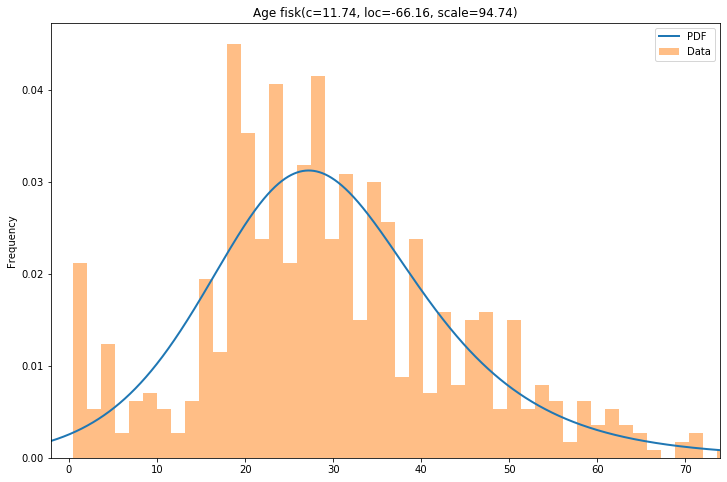

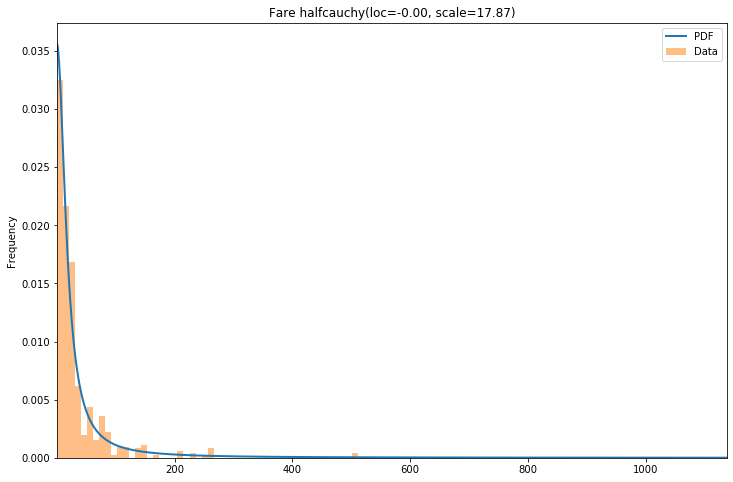

In [16]:
plot_result(df, continuous, best_distributions)

No we create a fucntion that generate similar data to the one we have.

In [44]:
def generate_like_df(df, categorical_cols, continuous_cols, best_distributions, n, seed=0):
    np.random.seed(seed)
    d = {}
    
    for c in categorical_cols:
        counts = df[c].value_counts()
        d[c] = np.random.choice(list(counts.index), p=(counts/len(df)).values, size=n)
        
                                
    for c, bd in zip(continuous_cols, best_distributions):
        dist = getattr(scipy.stats, bd[0])
        d[c] = dist.rvs(size=n, *bd[1])
        
    return pd.DataFrame(d, columns=categorical_cols+continuous_cols)

In [45]:
gendf = generate_like_df(df, categorical, continuous, best_distributions, n=100)
gendf.shape
gendf.head()

(100, 8)

,Survived,Pclass,SibSp,Parch,Sex,Embarked,Age,Fare
0,0,1,0,2,1,2,16.846655,11.866699
1,1,3,1,1,0,2,22.967661,6.523808
2,1,1,0,0,1,2,34.873726,2.272420
3,0,2,0,0,0,2,9.149005,2.408852
4,0,3,0,0,0,2,32.161475,6.477172


In [47]:
gendf.columns = list(range(gendf.shape[1]))
gendf.shape
gendf.head()

(100, 8)

,0,1,2,3,4,5,6,7
0,0,1,0,2,1,2,16.846655,11.866699
1,1,3,1,1,0,2,22.967661,6.523808
2,1,1,0,0,1,2,34.873726,2.272420
3,0,2,0,0,0,2,9.149005,2.408852
4,0,3,0,0,0,2,32.161475,6.477172


In [48]:
gendf.to_csv("output.csv", index_label="id")